# Brown University Propert Tax Viz

A visualization of the properties Brown University pays tax on. 

**Dataset source - https://data.providenceri.gov/**

The dataset has been cleaned, Brown University specific tax records extracted, the given address convert to lat/long and plotted using QGIS. 

The plots having a green square indicate properties for which the University paid tax and those in a red circle show the ones the University got an exemption. 


In [1]:
import pandas as pd
from IPython.display import display
from sodapy import Socrata
from time import sleep 

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [6]:
def extract_address(df): 
    """
    input: DataFrame with a column called "FORMATED_ADDRESS", "CITY", "ZIP_POSTAL"
    output: list of the address
    """
    list_adress = []
    for i in range(len(df)): 
        item = df.iloc[i]
        adress = str(item["FORMATED_ADDRESS"]) + ", " + str(item["CITY"]) + ", " + str(item["ZIP_POSTAL"])
        list_adress.append(adress)
    return list_adress

def extract_lat_long_address(address_list): 
    """
    input: A list of incomplete address 
    output: A list of tuples of the format: (lat, long, exact_address)
    """
    geolocator = Nominatim(user_agent="my_user_agent")
    iterator = 0
    return_list = []
    for item in address_list:
        iterator += 1
        if iterator % 15 == 0:
            sleep(5) 
            print("Sleeping") #So as to not hit a rate limit.
        try:
            loc = geolocator.geocode(item)
        except: 
            return_list.append((None, None, None))
            continue 
            
        try:
            return_list.append((loc.latitude, loc.longitude, loc.address))

        except: 
            return_list.append((None, None, None))
    
    return return_list
        

    
    

In [7]:
client = Socrata("data.providenceri.gov", None)
results = client.get("rv3y-tq8q")

In [8]:
df_2021 = pd.read_csv('../2021_Property_Tax_Roll.csv')
df_2020 = pd.read_csv('../2020_Property_Tax_Roll.csv')

df_2021.rename(columns = {'OWNER COMPANY':'owner'}, inplace = True)
df_2020.rename(columns = {'OWNER COMPANY':'owner'}, inplace = True)

In [9]:
names = ['RHODE ISLAND SCHOOL OF DESIGN','Brown University','brown university']
df_2021 = df_2021[df_2021.owner.isin(names)]
df_2020 = df_2020[df_2020.owner.isin(names)]

In [132]:
#Adding complete address, lattitude and longitude to every entry. Only for 2021 
address_list = extract_address(df_2021)
new_cols = extract_lat_long_address(address_list)

latitude = []
longitude = []
address = []
for item in new_cols: 
    latitude.append(item[0])
    longitude.append(item[1])
    address.append(item[2])
    
df_2021['Latitude'] = latitude
df_2021['Longitude'] = longitude
df_2021['Address'] = address

df_2021.to_csv("2021_with_address_and_latlong.csv")


In [173]:
temp_list = []
for i in range(len(df_2021)): 
    item = df_2021.iloc[i]
    if str(item["TOTAL TAXES"]) != "nan": #No tax paid.
        temp_list.append("PAID")
    else: 
        temp_list.append("EXEMPT")

df_2021["STATUS"] = temp_list

In [175]:
df_2021.to_csv("Plot.csv") # CSV plotted in QGIS.

### Property tax has remained the same for all Brown University properties from FY 2020 - 2021

In [12]:
#Code shpwing the above statement

for i in range(0, len(df_2021)):
    item = df_2021.iloc[i]
    address = item["FORMATED_ADDRESS"]
    item_early = df_2020.loc[df_2020['FORMATED_ADDRESS'] == address]
#     print(address, str(item["TOTAL TAXES"]), str(item_early["TOTAL TAXES"]))
    tax2021 = item["TOTAL TAXES"]
    tax2020 = item_early["TOTAL TAXES"]
    try:
        if int(tax2021) - int(tax2020) != 0: 
            print(item)
    except: 
        continue

    

## Plot 
(Legened) - The plots having a green square indicate properties for which the University paid tax and those in a red circle show the ones the University got an exemption. A QGIS expression was used to differentiate the symbols based on whether taxes have been paid or exempt.

### Error 
- Two datapoints got the wrong lat/long extracted and were plotted in Nashville, TN. This is likely due to similar street names. However, the exact cause is yet to be debugged as the zip code was provided. 


### Zoomed Out

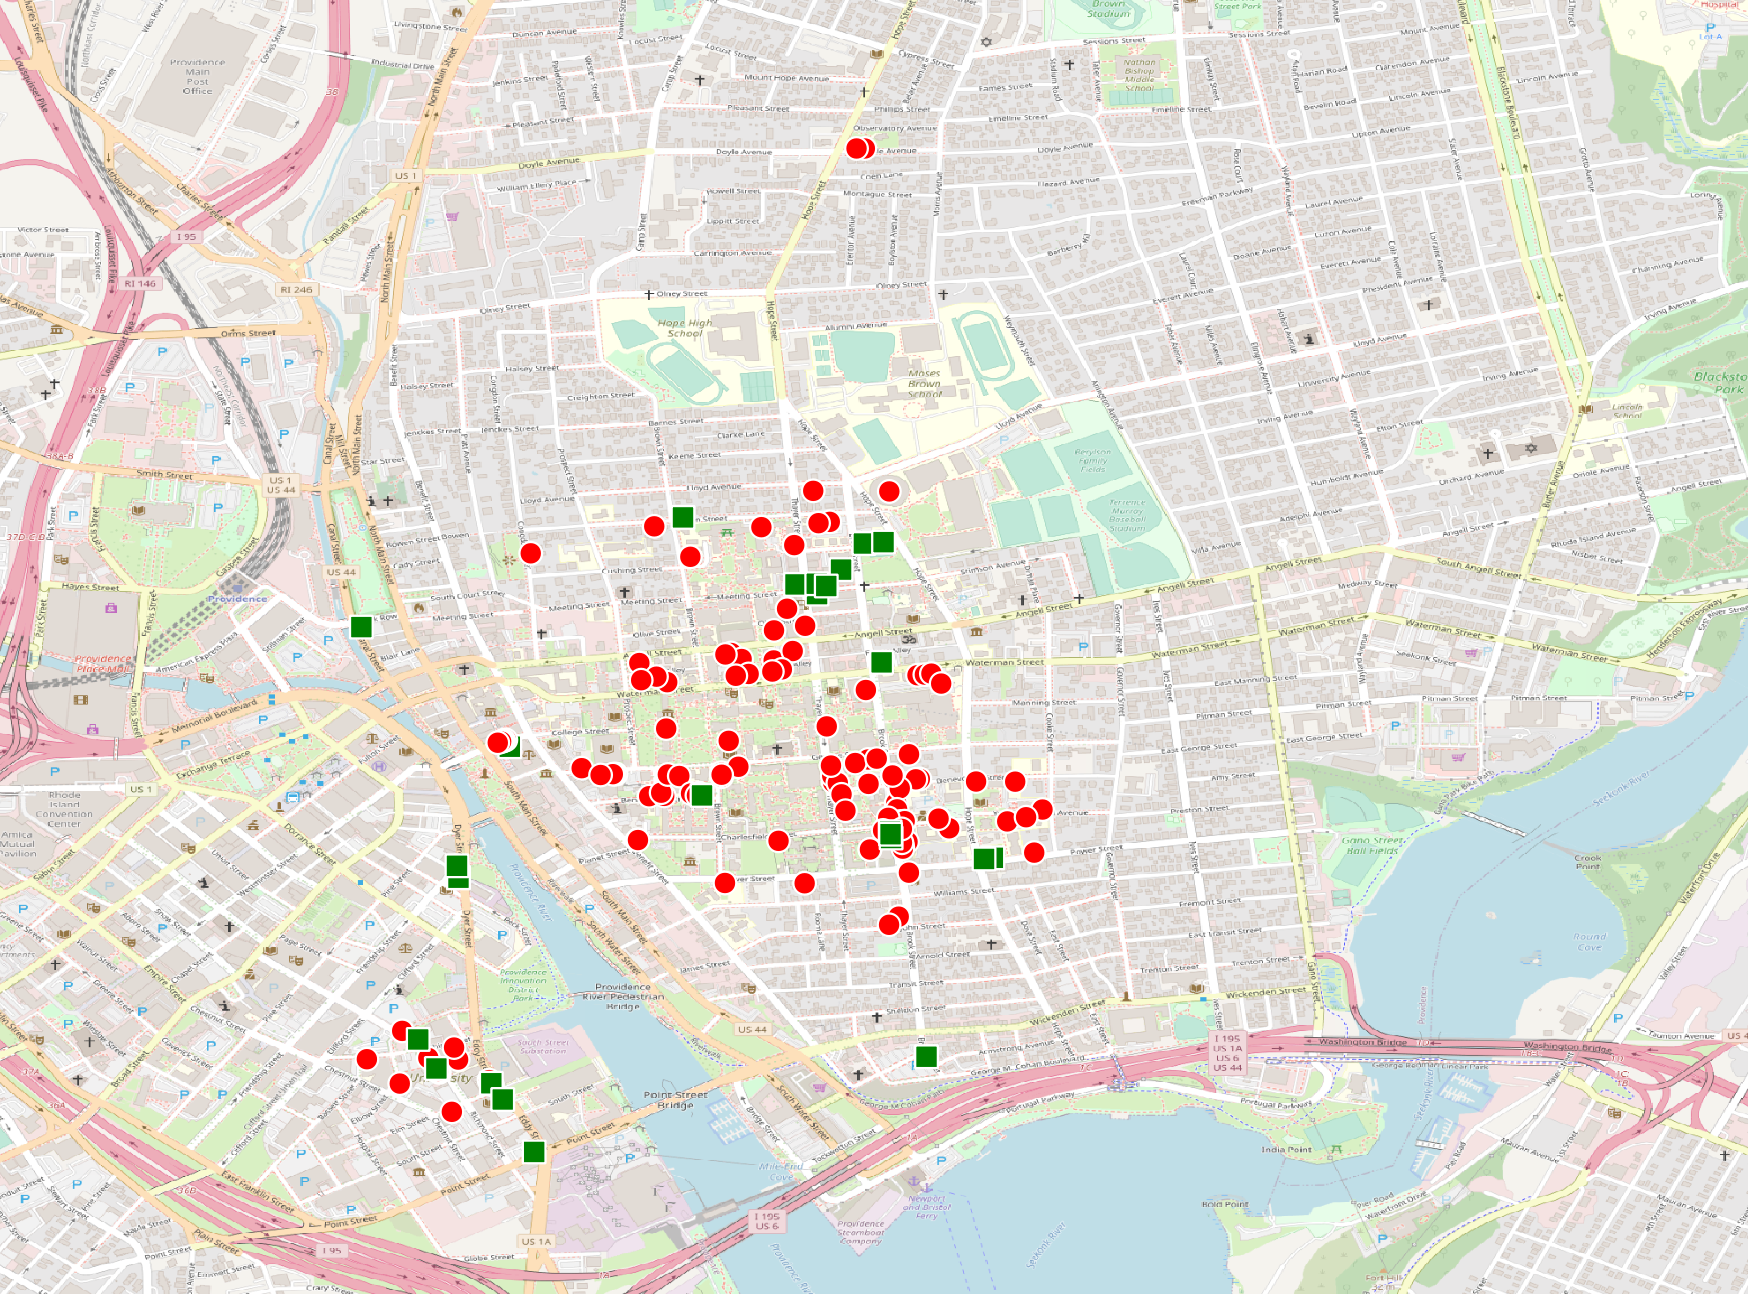

### Zoomed In


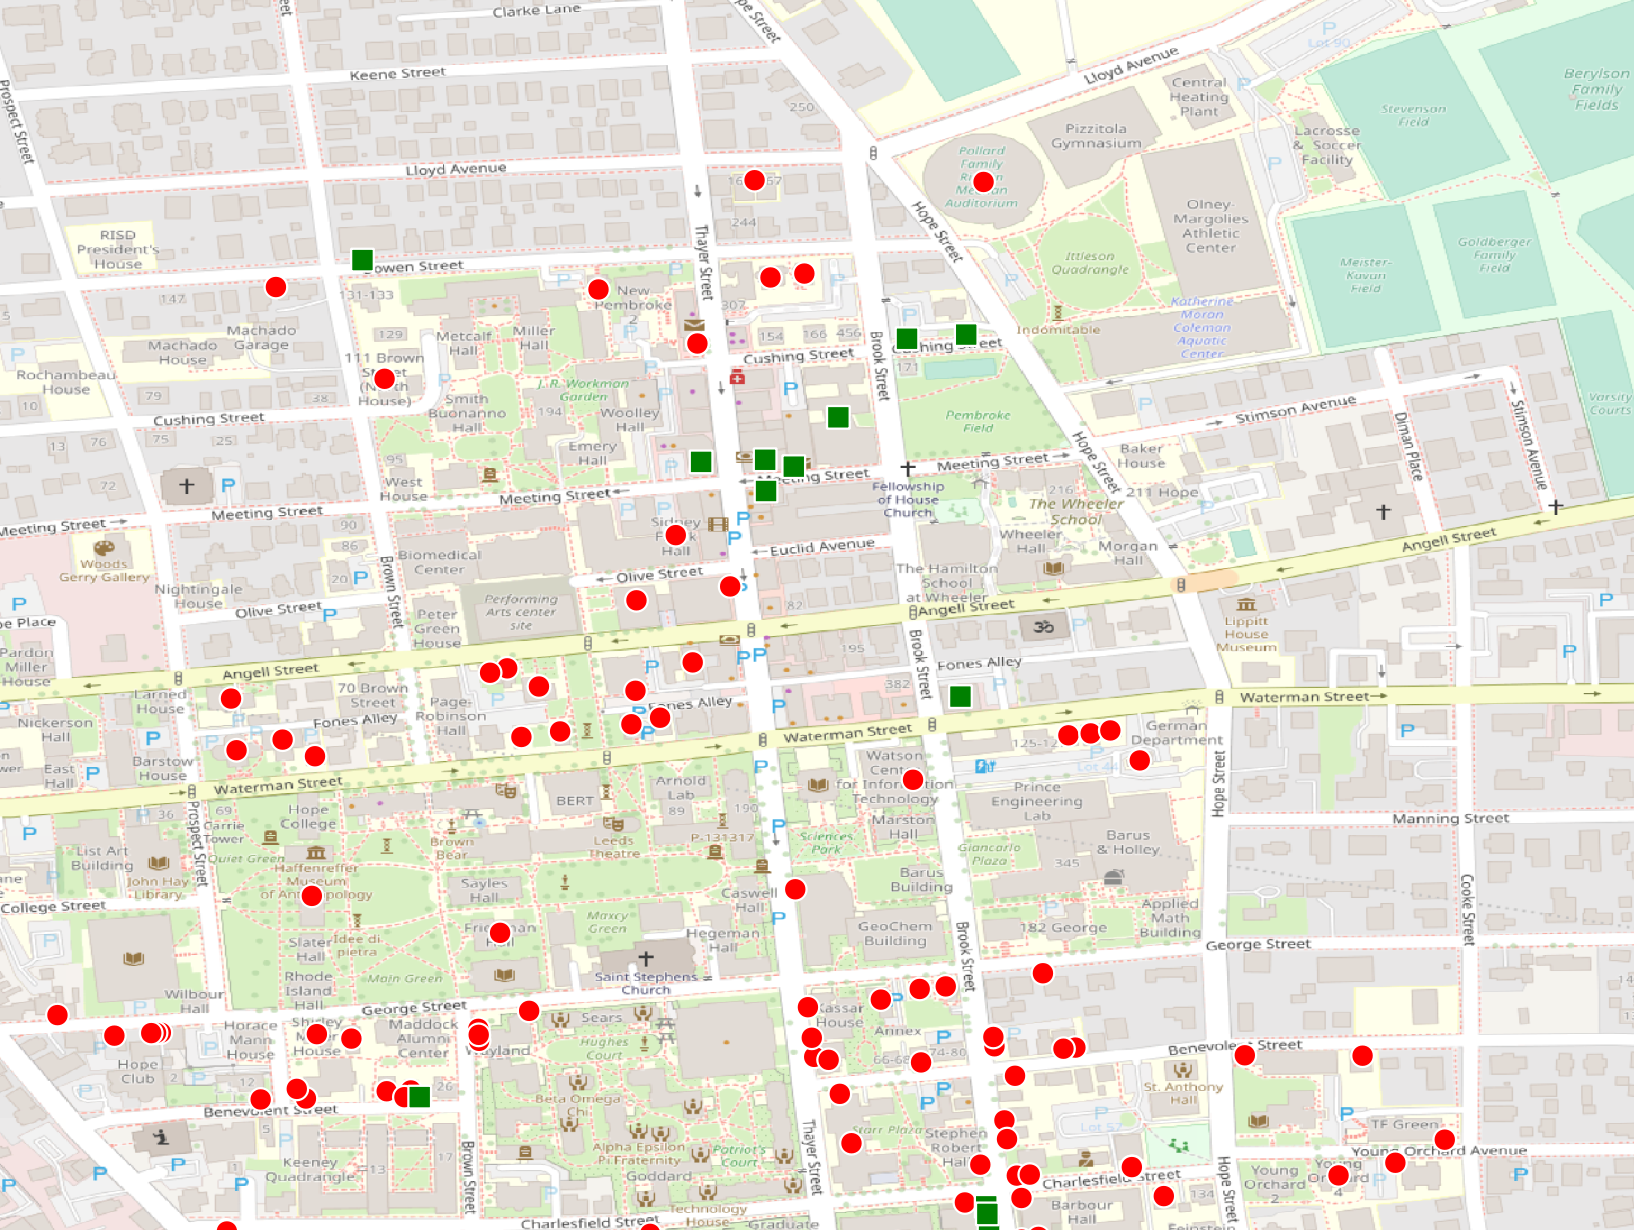

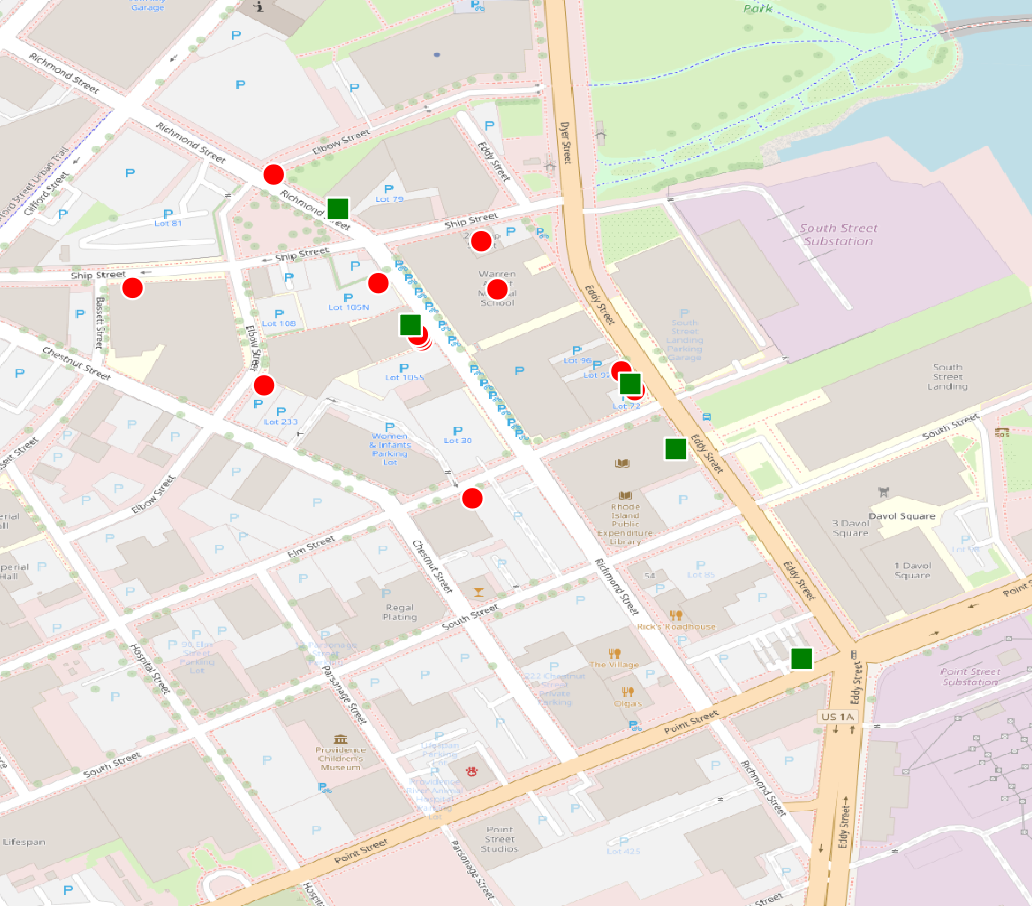